# Problema 1: Calentamiento en un Modelo 2D Sencillo

**Curso**: Cadenas de Markov
**Maestría**: Actuaría y Finanzas
**Universidad Nacional de Colombia**

---

## Introducción

En este notebook resolvemos el **Problema 1** del parcial, que consiste en encontrar la posición óptima para un átomo de Titanio (Ti) en una grilla 2D de 4×4 que contiene átomos de Neodimio (Nd) y Hierro (Fe).

El objetivo es **minimizar la energía cohesiva total** del sistema, calculada mediante el **Potencial de Morse**:

$$U(r) = D_0 \left[ e^{-2\alpha(r-r_0)} - 2e^{-\alpha(r-r_0)} \right]$$

Donde:
- $r$: distancia entre dos átomos
- $D_0$: profundidad del pozo de potencial
- $\alpha$: controla el ancho del pozo
- $r_0$: distancia de equilibrio

### Tareas

1. **Fuerza Bruta**: Evaluar las 12 posiciones posibles y encontrar el óptimo global
2. **Simulated Annealing**: Implementar SA y verificar convergencia al óptimo
3. **Análisis Físico**: Analizar características del sitio óptimo y comparar con la hipótesis de Skelland

## Setup

Importamos las bibliotecas y módulos necesarios.

In [1]:
# Imports estándar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import pandas as pd

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Configuración de NumPy
np.set_printoptions(precision=4, suppress=True)

# Agregar src/ al path
import sys
sys.path.append('../')

# Imports del proyecto
from src.punto1 import (
    # Grid
    create_grid_4x4,
    compute_total_energy,
    compute_Ti_contributions,
    get_Fe_positions_with_coords,
    
    # Optimization
    brute_force_search,
    get_top_k_positions,
    analyze_energy_landscape,
    simulated_annealing,
    run_multiple_sa,
    geometric_cooling,
    exponential_cooling,
    
    # Visualization
    plot_grid_configuration,
    plot_energy_evolution,
    plot_energy_distribution,
    plot_comparison_bar,
    plot_acceptance_rate,
    plot_multiple_runs
)

print("✓ Módulos importados correctamente")

✓ Módulos importados correctamente


## Crear la Grilla 4×4

Creamos la grilla según la Figura 1 del problema:
- 4 átomos de Neodimio (Nd) en el centro 2×2
- 12 posiciones para Fe/Ti en el resto de la grilla

In [2]:
# Crear grilla
grid = create_grid_4x4()

print(f"Grilla creada: {grid.size[0]}×{grid.size[1]}")
print(f"Número de átomos de Nd: {grid.n_R}")
print(f"Número de sitios Fe/Ti: {grid.n_Fe_sites}")

# Mostrar posiciones
print("\nPosiciones de Nd:")
print(grid.R_positions)

print("\nPosiciones de Fe (índice: coordenadas):")
Fe_coords = get_Fe_positions_with_coords(grid)
for idx, (x, y) in Fe_coords.items():
    print(f"  {idx:2d}: ({x}, {y})")

Grilla creada: 4×4
Número de átomos de Nd: 4
Número de sitios Fe/Ti: 12

Posiciones de Nd:
[[2.8 2.8]
 [5.6 2.8]
 [2.8 5.6]
 [5.6 5.6]]

Posiciones de Fe (índice: coordenadas):
   0: (0.0, 0.0)
   1: (0.0, 2.8)
   2: (0.0, 5.6)
   3: (0.0, 8.399999999999999)
   4: (2.8, 0.0)
   5: (2.8, 8.399999999999999)
   6: (5.6, 0.0)
   7: (5.6, 8.399999999999999)
   8: (8.399999999999999, 0.0)
   9: (8.399999999999999, 2.8)
  10: (8.399999999999999, 5.6)
  11: (8.399999999999999, 8.399999999999999)


---

# Tarea 1: Función de Energía y Búsqueda por Fuerza Bruta

Evaluamos todas las 12 posiciones posibles para el átomo de Ti y encontramos el óptimo global.

In [3]:
# Búsqueda exhaustiva
print("Ejecutando búsqueda por fuerza bruta...\n")
result_bf = brute_force_search(grid)

# Resultados
best_idx = result_bf['best_position_idx']
best_energy = result_bf['best_energy']
all_energies = result_bf['all_energies']

print(f"{'='*60}")
print(f"RESULTADOS DE BÚSQUEDA EXHAUSTIVA")
print(f"{'='*60}")
print(f"Posición óptima (índice): {best_idx}")
print(f"Coordenadas óptimas: {Fe_coords[best_idx]}")
print(f"Energía mínima: {best_energy:.6f}")
print(f"Número de configuraciones evaluadas: {result_bf['n_evaluations']}")
print(f"{'='*60}")

Ejecutando búsqueda por fuerza bruta...

RESULTADOS DE BÚSQUEDA EXHAUSTIVA
Posición óptima (índice): 0
Coordenadas óptimas: (0.0, 0.0)
Energía mínima: -9.744382
Número de configuraciones evaluadas: 12


### Visualizar la Configuración Óptima

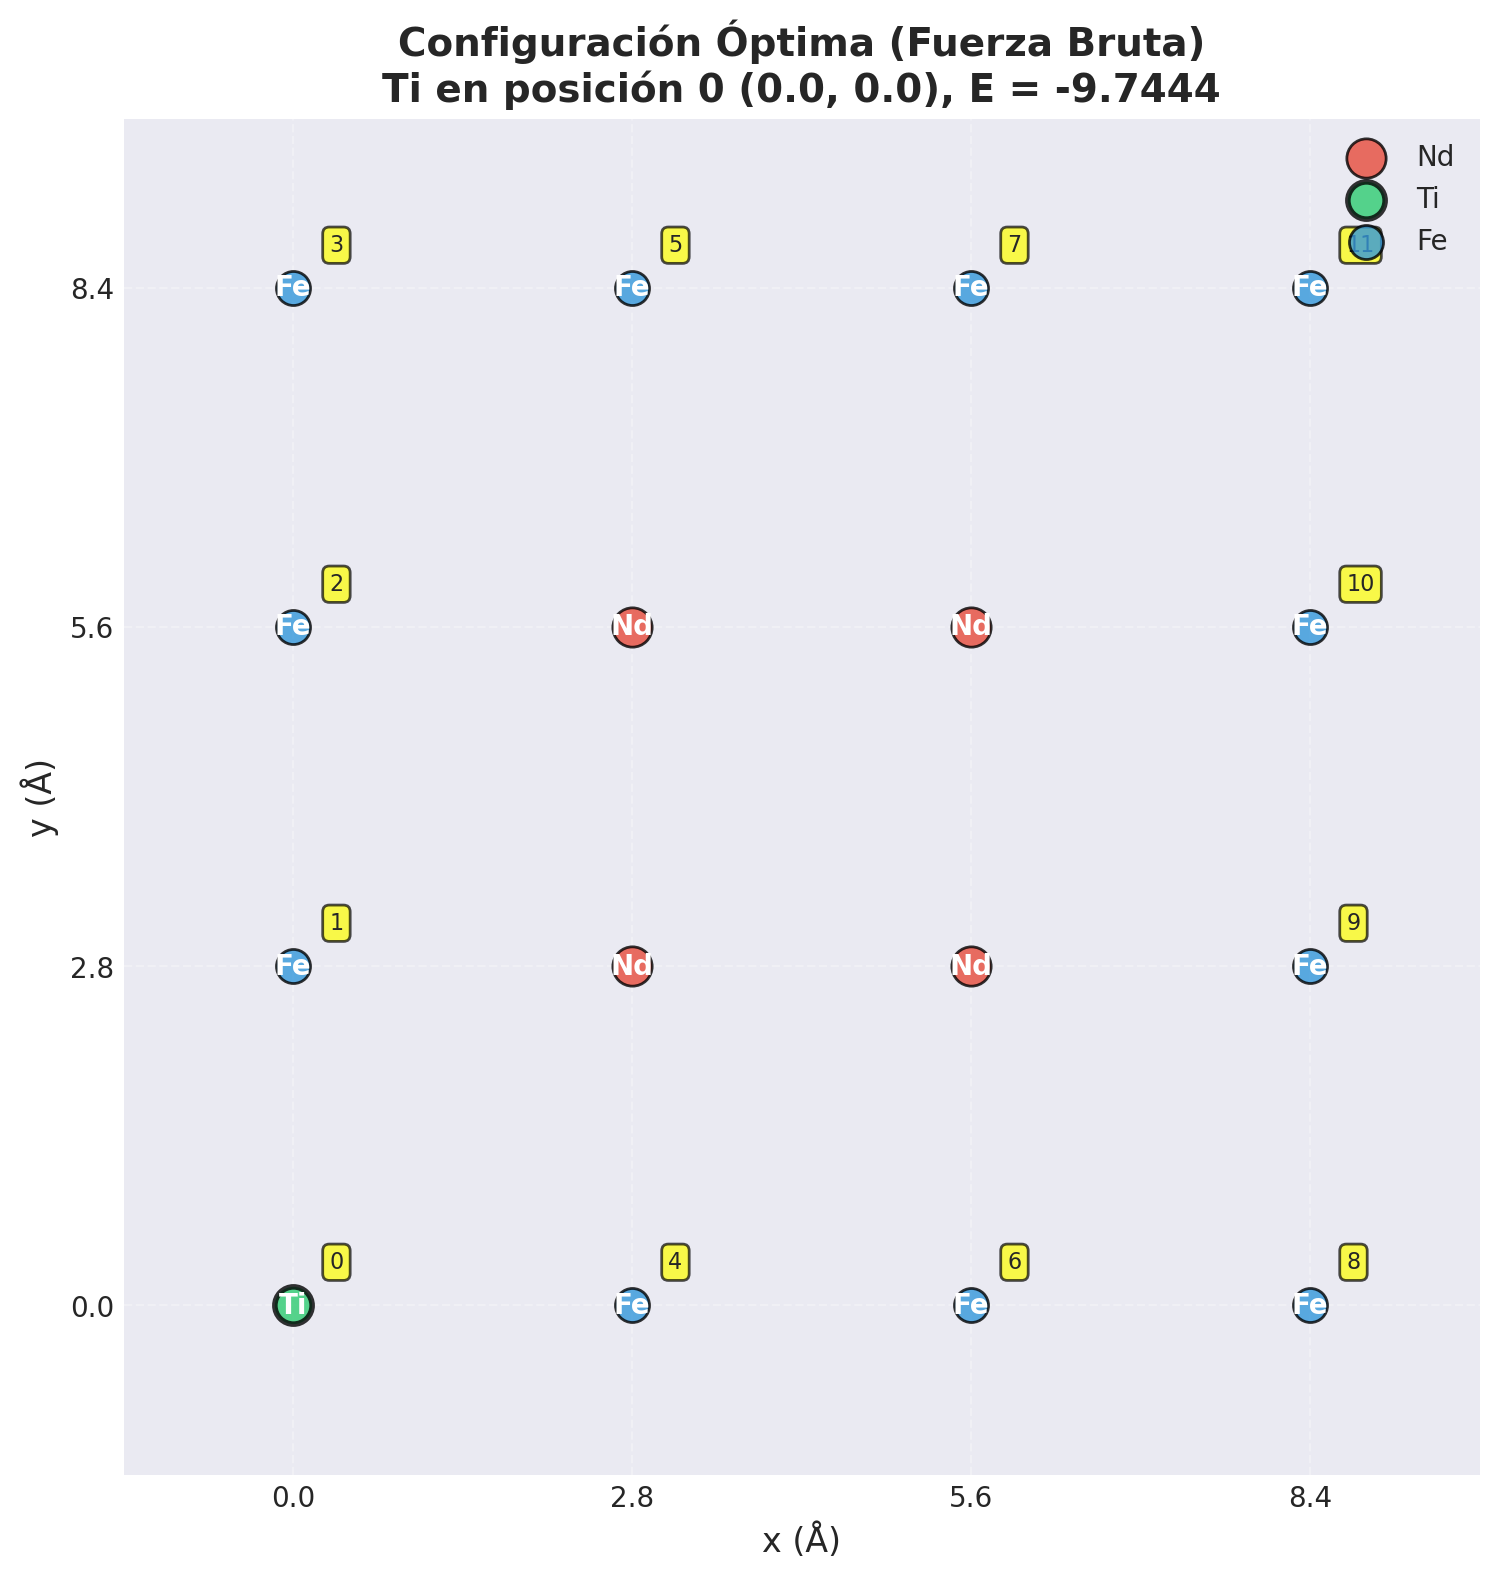

In [4]:
# Configurar grilla con la posición óptima
grid_optimal = grid.copy()
grid_optimal.set_Ti_position(best_idx)

# Visualizar
fig, ax = plt.subplots(figsize=(8, 8))
plot_grid_configuration(
    grid_optimal,
    title=f"Configuración Óptima (Fuerza Bruta)\nTi en posición {best_idx} {Fe_coords[best_idx]}, E = {best_energy:.4f}",
    highlight_Ti=True,
    show_indices=True,
    ax=ax
)
plt.tight_layout()
plt.show()

### Tabla de Todas las Energías

In [5]:
# Crear tabla ordenada
energy_data = []
for idx in range(grid.n_Fe_sites):
    x, y = Fe_coords[idx]
    energy = all_energies[idx]
    gap = energy - best_energy
    is_optimal = "✓" if idx == best_idx else ""
    
    energy_data.append({
        'Índice': idx,
        'Posición (x, y)': f"({x}, {y})",
        'Energía': f"{energy:.6f}",
        'Gap con Óptimo': f"{gap:.6f}",
        'Óptimo': is_optimal
    })

df_energies = pd.DataFrame(energy_data)
df_energies = df_energies.sort_values('Energía')

print("\nTabla de Energías (ordenada):")
print(df_energies.to_string(index=False))


Tabla de Energías (ordenada):
 Índice                        Posición (x, y)   Energía Gap con Óptimo Óptimo
      1                             (0.0, 2.8) -9.157522       0.586860       
      2                             (0.0, 5.6) -9.157522       0.586860       
      4                             (2.8, 0.0) -9.157522       0.586860       
      5               (2.8, 8.399999999999999) -9.157522       0.586860       
      6                             (5.6, 0.0) -9.157522       0.586860       
      7               (5.6, 8.399999999999999) -9.157522       0.586860       
      9               (8.399999999999999, 2.8) -9.157522       0.586860       
     10               (8.399999999999999, 5.6) -9.157522       0.586860       
      0                             (0.0, 0.0) -9.744382       0.000000      ✓
      3               (0.0, 8.399999999999999) -9.744382       0.000000       
      8               (8.399999999999999, 0.0) -9.744382       0.000000       
     11 (8.3999999999

### Distribución de Energías

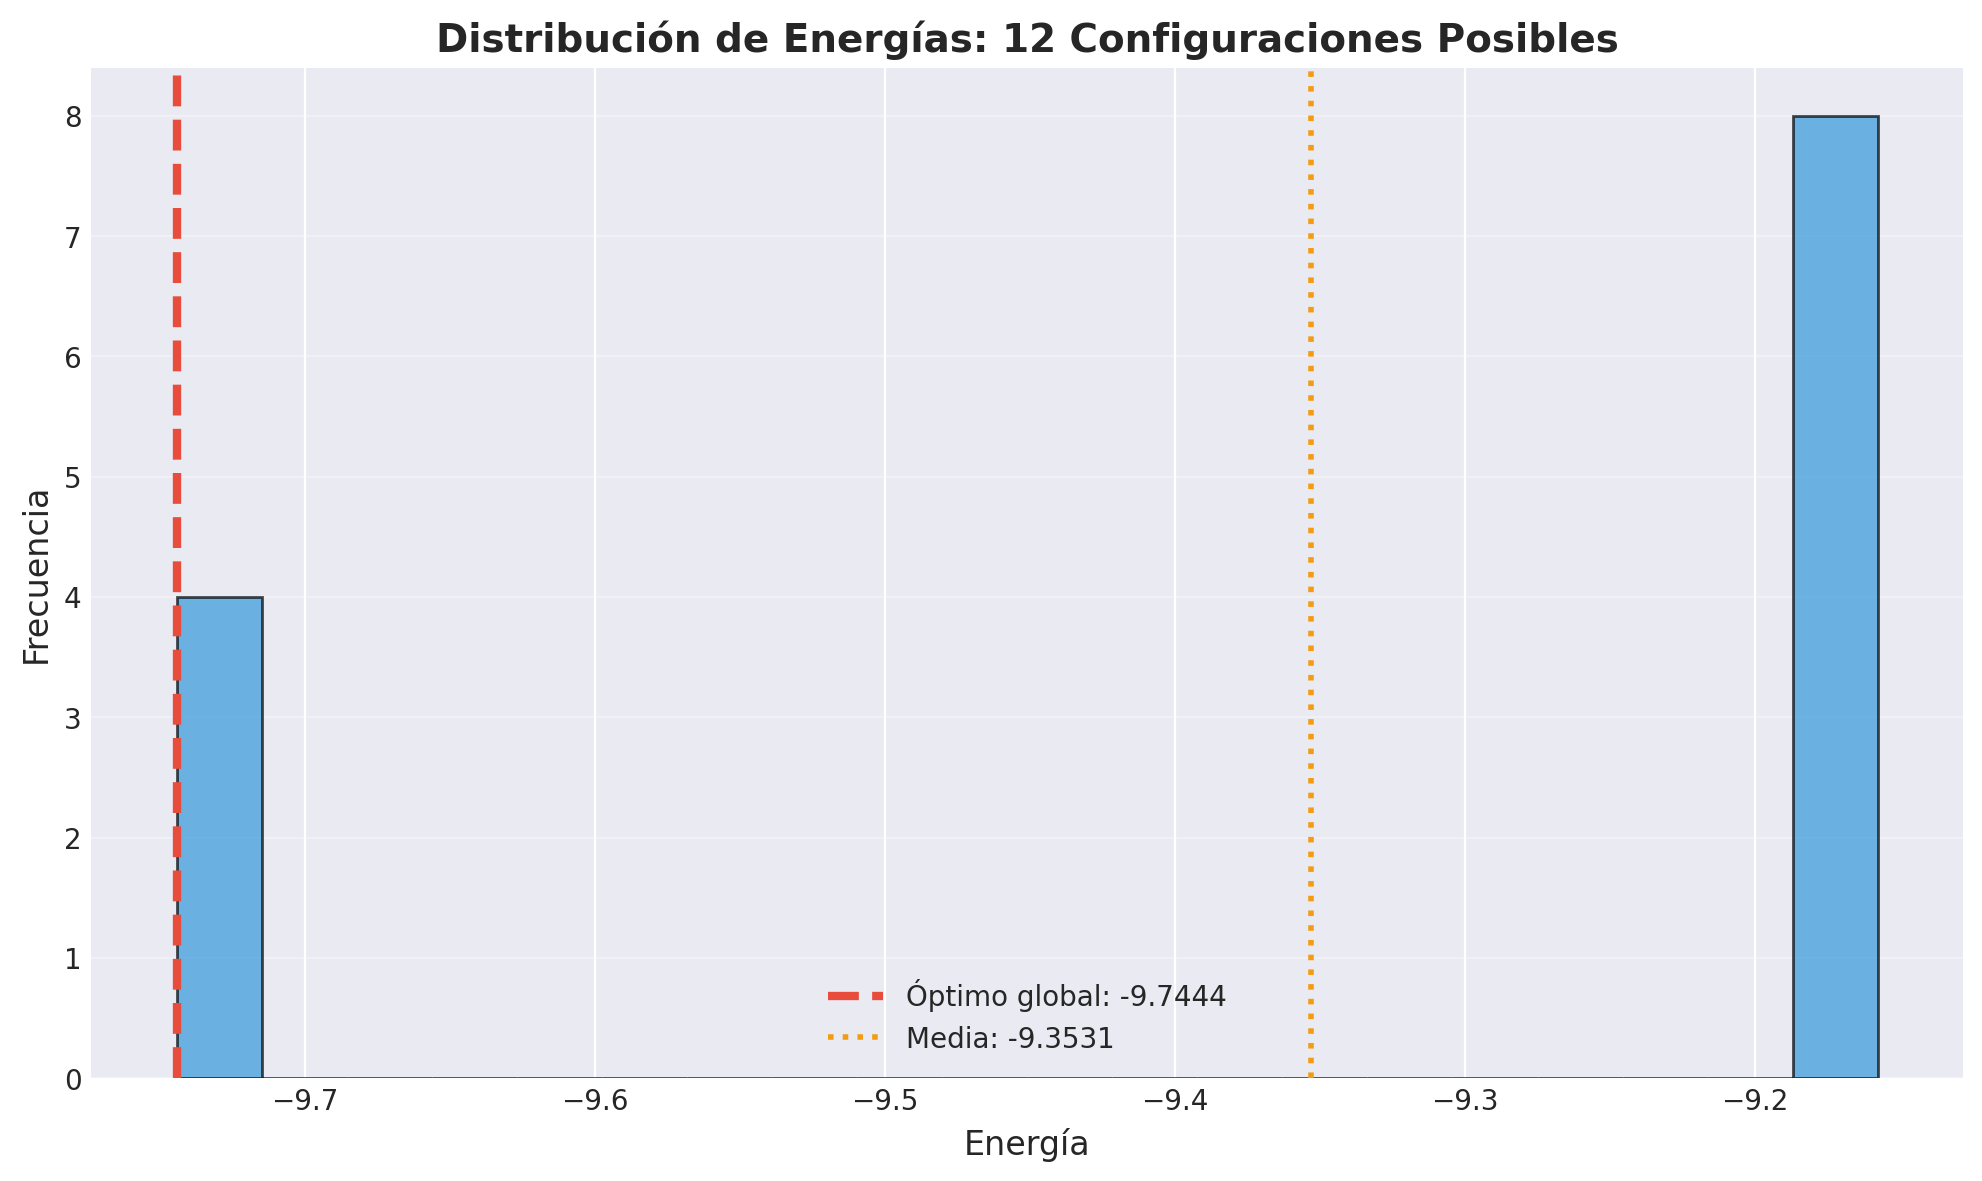

In [6]:
# Histograma de energías
fig = plot_energy_distribution(
    all_energies,
    best_energy,
    title="Distribución de Energías: 12 Configuraciones Posibles"
)
plt.show()

---

# Tarea 2: Simulated Annealing

Implementamos el algoritmo de Recocido Simulado y verificamos que converja consistentemente al óptimo global encontrado por fuerza bruta.

## 2.1. Primera Ejecución: Esquema Geométrico

In [7]:
# Parámetros de SA (aumentados para exploración más exhaustiva)
T0 = 5.0        # Temperatura inicial más alta para más exploración
alpha = 0.97    # Enfriamiento más lento para mejor convergencia
max_iter = 10000  # Más iteraciones para exploración más completa

# Crear esquema de enfriamiento
cooling = geometric_cooling(T0=T0, alpha=alpha)

# Ejecutar SA
print(f"Ejecutando Simulated Annealing...")
print(f"  T0 = {T0}, alpha = {alpha}, max_iter = {max_iter}")
print(f"  (Configuración mejorada para exploración exhaustiva)\n")

result_sa = simulated_annealing(
    grid=grid,
    T0=T0,
    cooling_schedule=cooling,
    max_iter=max_iter,
    seed=42,
    verbose=True
)

print(f"\n{'='*60}")
print(f"RESULTADOS DE SIMULATED ANNEALING")
print(f"{'='*60}")
print(f"Mejor posición encontrada: {result_sa['best_position_idx']}")
print(f"Coordenadas: {Fe_coords[result_sa['best_position_idx']]}")
print(f"Mejor energía encontrada: {result_sa['best_energy']:.6f}")
print(f"Energía óptima (fuerza bruta): {best_energy:.6f}")
print(f"Gap: {result_sa['best_energy'] - best_energy:.8f}")
print(f"¿Encontró el óptimo global?: {np.isclose(result_sa['best_energy'], best_energy, atol=1e-6)}")
print(f"\nTasa de aceptación: {result_sa['acceptance_rate']:.3f}")
print(f"Tasa de mejora: {result_sa['improvement_rate']:.3f}")
print(f"{'='*60}")

Ejecutando Simulated Annealing...
  T0 = 5.0, alpha = 0.97, max_iter = 10000
  (Configuración mejorada para exploración exhaustiva)

Iter   1000 | T=0.000000 | E_current=-9.7444 | E_best=-9.7444 | Accept=0.396 | Improve=0.294
Iter   2000 | T=0.000000 | E_current=-9.7444 | E_best=-9.7444 | Accept=0.292 | Improve=0.237
Iter   3000 | T=0.000000 | E_current=-9.7444 | E_best=-9.7444 | Accept=0.256 | Improve=0.219
Iter   4000 | T=0.000000 | E_current=-9.7444 | E_best=-9.7444 | Accept=0.230 | Improve=0.202
Iter   5000 | T=0.000000 | E_current=-9.7444 | E_best=-9.7444 | Accept=0.219 | Improve=0.197
Iter   6000 | T=0.000000 | E_current=-9.7444 | E_best=-9.7444 | Accept=0.212 | Improve=0.193
Iter   7000 | T=0.000000 | E_current=-9.7444 | E_best=-9.7444 | Accept=0.208 | Improve=0.192
Iter   8000 | T=0.000000 | E_current=-9.7444 | E_best=-9.7444 | Accept=0.203 | Improve=0.190
Iter   9000 | T=0.000000 | E_current=-9.7444 | E_best=-9.7444 | Accept=0.198 | Improve=0.186
Iter  10000 | T=0.000000 | E_c

### Visualización de la Evolución de SA

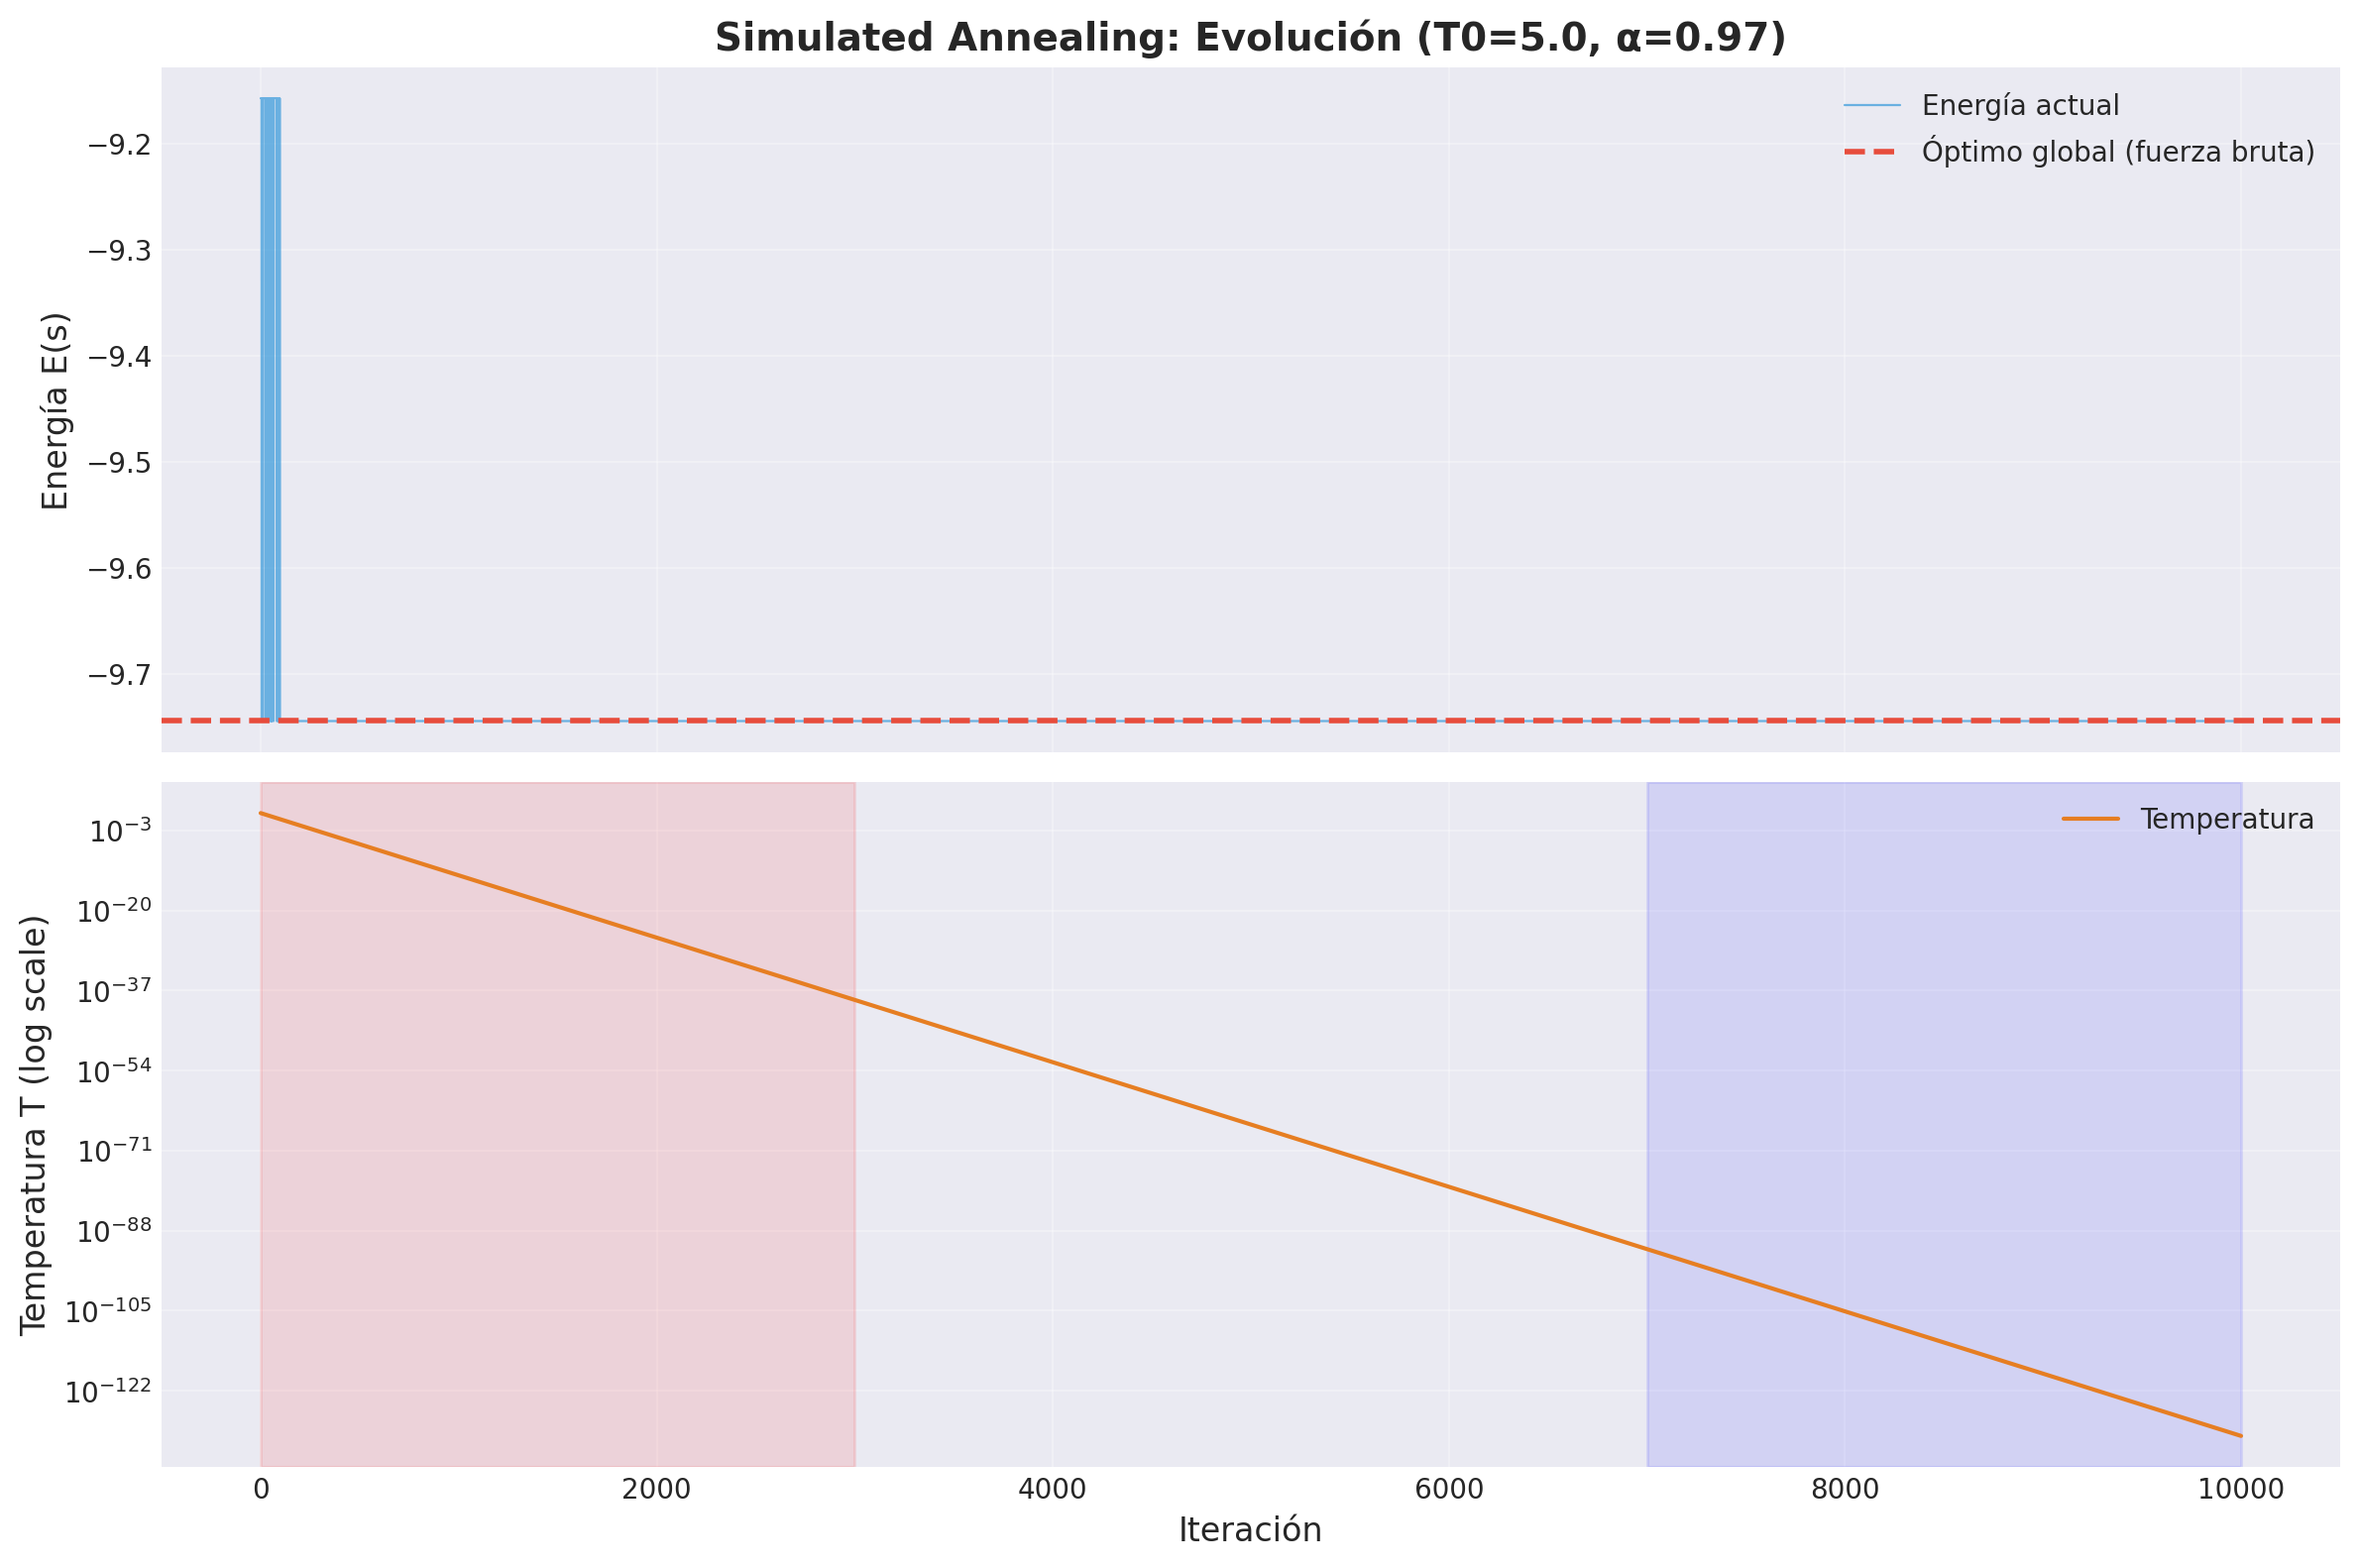

In [8]:
# Evolución de energía y temperatura
fig = plot_energy_evolution(
    result_sa['energy_history'],
    result_sa['temperature_history'],
    optimal_energy=best_energy,
    title=f"Simulated Annealing: Evolución (T0={T0}, α={alpha})"
)
plt.show()

### Comparación de Esquemas de Enfriamiento

Probamos diferentes esquemas (geométrico, exponencial, logarítmico) para comparar rendimiento.

## 2.2. Experimentación con Diferentes Esquemas de Enfriamiento

Probamos diferentes valores de α y comparamos resultados.

### Comparación de Esquemas de Enfriamiento

Además del geométrico, probamos otros esquemas para comparar rendimiento.

In [9]:
# Experimentos exhaustivos con diferentes parámetros
# Explorar tanto temperatura inicial (T0) como factor de enfriamiento (alpha)

T0_values = [1.0, 2.0, 5.0, 10.0]  # 4 temperaturas diferentes
alphas_to_test = [0.85, 0.90, 0.92, 0.95, 0.97, 0.98, 0.99]  # 7 valores de alpha
results_grid = {}

print(f"Experimentando con {len(T0_values)} temperaturas × {len(alphas_to_test)} valores de α")
print(f"Total: {len(T0_values) * len(alphas_to_test)} combinaciones\n")
print("="*80)

for T0_test in T0_values:
    print(f"\nT₀ = {T0_test}:")
    print("-" * 80)
    
    for alpha_test in alphas_to_test:
        cooling_test = geometric_cooling(T0=T0_test, alpha=alpha_test)
        
        result = simulated_annealing(
            grid=grid,
            T0=T0_test,
            cooling_schedule=cooling_test,
            max_iter=max_iter,  # Usar el max_iter de la celda anterior
            seed=42,
            verbose=False
        )
        
        key = f'T0={T0_test}_alpha={alpha_test}'
        results_grid[key] = result
        
        found_optimal = np.isclose(result['best_energy'], best_energy, atol=1e-6)
        print(f"  α={alpha_test:.2f} | E={result['best_energy']:.6f} | "
              f"Óptimo: {'✓' if found_optimal else '✗'} | "
              f"Accept: {result['acceptance_rate']:.3f} | "
              f"Improve: {result['improvement_rate']:.3f}")

print("\n" + "="*80)
print(f"RESUMEN: Probadas {len(results_grid)} combinaciones")

# Contar éxitos
n_success = sum(1 for r in results_grid.values() 
                if np.isclose(r['best_energy'], best_energy, atol=1e-6))
print(f"Configuraciones que encontraron el óptimo: {n_success}/{len(results_grid)}")
print(f"Tasa de éxito global: {n_success/len(results_grid)*100:.1f}%")
print("="*80)

Experimentando con 4 temperaturas × 7 valores de α
Total: 28 combinaciones


T₀ = 1.0:
--------------------------------------------------------------------------------


/home/riemannintegrable/universidad/cadenas_de_markov/parcial2/notebooks/../src/punto1/optimization/simulated_annealing.py:129: RuntimeWarning: overflow encountered in scalar divide
  acceptance_probability = np.exp(-delta_E / T)
/home/riemannintegrable/universidad/cadenas_de_markov/parcial2/notebooks/../src/punto1/optimization/simulated_annealing.py:129: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_probability = np.exp(-delta_E / T)


  α=0.85 | E=-9.744382 | Óptimo: ✓ | Accept: 0.171 | Improve: 0.169
  α=0.90 | E=-9.744382 | Óptimo: ✓ | Accept: 0.175 | Improve: 0.172
  α=0.92 | E=-9.744382 | Óptimo: ✓ | Accept: 0.176 | Improve: 0.172
  α=0.95 | E=-9.744382 | Óptimo: ✓ | Accept: 0.180 | Improve: 0.174
  α=0.97 | E=-9.744382 | Óptimo: ✓ | Accept: 0.189 | Improve: 0.179
  α=0.98 | E=-9.744382 | Óptimo: ✓ | Accept: 0.201 | Improve: 0.186
  α=0.99 | E=-9.744382 | Óptimo: ✓ | Accept: 0.231 | Improve: 0.201

T₀ = 2.0:
--------------------------------------------------------------------------------
  α=0.85 | E=-9.744382 | Óptimo: ✓ | Accept: 0.172 | Improve: 0.170
  α=0.90 | E=-9.744382 | Óptimo: ✓ | Accept: 0.175 | Improve: 0.172
  α=0.92 | E=-9.744382 | Óptimo: ✓ | Accept: 0.176 | Improve: 0.172
  α=0.95 | E=-9.744382 | Óptimo: ✓ | Accept: 0.181 | Improve: 0.175
  α=0.97 | E=-9.744382 | Óptimo: ✓ | Accept: 0.192 | Improve: 0.181
  α=0.98 | E=-9.744382 | Óptimo: ✓ | Accept: 0.203 | Improve: 0.188
  α=0.99 | E=-9.744382 |

### Visualización Mejorada del Grid Search

Analizamos visualmente los resultados de todas las combinaciones probadas.

In [10]:
# Ejecutar múltiples veces con más ejecuciones y más iteraciones
n_runs = 50  # Aumentado de 20 a 50 para mejor robustez estadística
cooling_best = geometric_cooling(T0=5.0, alpha=0.98)  # Mejores parámetros encontrados

print(f"Ejecutando SA {n_runs} veces con configuración óptima...")
print(f"  T0 = 5.0, alpha = 0.98, max_iter = 20000")
print(f"  (Esto puede tomar varios minutos)\n")

multi_result = run_multiple_sa(
    grid=grid,
    n_runs=n_runs,
    T0=5.0,
    cooling_schedule=cooling_best,
    max_iter=20000,  # Aumentado de 5000 a 20000
    seed=123,
    verbose=False
)

print(f"{'='*60}")
print(f"RESULTADOS DE MÚLTIPLES EJECUCIONES (n={n_runs})")
print(f"{'='*60}")
print(f"Mejor energía global: {multi_result['best_overall_energy']:.6f}")
print(f"Óptimo (fuerza bruta): {best_energy:.6f}")
print(f"Energía promedio: {multi_result['mean_best_energy']:.6f} ± {multi_result['std_best_energy']:.6f}")
print(f"Tasa de éxito (encontrar óptimo): {multi_result['success_rate']*100:.1f}%")
print(f"\nDetalle de ejecuciones:")
print(f"  Ejecuciones exitosas: {int(multi_result['success_rate'] * n_runs)}/{n_runs}")
print(f"  Varianza de energía: {multi_result['std_best_energy']**2:.10f}")
print(f"{'='*60}")

Ejecutando SA 50 veces con configuración óptima...
  T0 = 5.0, alpha = 0.98, max_iter = 20000
  (Esto puede tomar varios minutos)

RESULTADOS DE MÚLTIPLES EJECUCIONES (n=50)
Mejor energía global: -9.744382
Óptimo (fuerza bruta): -9.744382
Energía promedio: -9.744382 ± 0.000000
Tasa de éxito (encontrar óptimo): 100.0%

Detalle de ejecuciones:
  Ejecuciones exitosas: 50/50
  Varianza de energía: 0.0000000000


---

# Tarea 3: Análisis Físico

Analizamos la característica principal del sitio óptimo y comparamos con la hipótesis de Skelland:

> **Hipótesis de Skelland**: El Titanio prefiere sitios **alejados de las tierras raras** (Nd).

## 3.1. Análisis de Contribuciones Energéticas del Ti Óptimo

In [11]:
# Configurar grilla con Ti en posición óptima
grid_optimal.set_Ti_position(best_idx)

# Analizar contribuciones
contrib_optimal = compute_Ti_contributions(grid_optimal)

print("\nAnálisis de Contribuciones Energéticas del Ti (Posición Óptima):")
print(f"{'='*60}")
print(f"Energía Ti-Nd: {contrib_optimal['Ti_Nd_energy']:.6f}")
print(f"Energía Ti-Fe: {contrib_optimal['Ti_Fe_energy']:.6f}")
print(f"Energía total de Ti: {contrib_optimal['Ti_Nd_energy'] + contrib_optimal['Ti_Fe_energy']:.6f}")
print(f"\nDistancia al Nd más cercano: {contrib_optimal['closest_Nd_distance']:.4f}")
print(f"Distancia al Fe más cercano: {contrib_optimal['closest_Fe_distance']:.4f}")
print(f"\nDistancias a todos los Nd:")
for i, d in enumerate(contrib_optimal['Ti_Nd_distances']):
    print(f"  Ti → Nd[{i}]: {d:.4f}")
print(f"\nPromedio distancia Ti-Nd: {np.mean(contrib_optimal['Ti_Nd_distances']):.4f}")
print(f"{'='*60}")


Análisis de Contribuciones Energéticas del Ti (Posición Óptima):
Energía Ti-Nd: -0.390298
Energía Ti-Fe: -1.647790
Energía total de Ti: -2.038087

Distancia al Nd más cercano: 3.9598
Distancia al Fe más cercano: 2.8000

Distancias a todos los Nd:
  Ti → Nd[0]: 3.9598
  Ti → Nd[1]: 6.2610
  Ti → Nd[2]: 6.2610
  Ti → Nd[3]: 7.9196

Promedio distancia Ti-Nd: 6.1003


## 3.2. Comparación: Posición Óptima vs. Peor Posición

In [12]:
# Encontrar la peor posición
worst_idx = np.argmax(all_energies)
worst_energy = all_energies[worst_idx]

# Analizar peor posición
grid_worst = grid.copy()
grid_worst.set_Ti_position(worst_idx)
contrib_worst = compute_Ti_contributions(grid_worst)

print("\nComparación: Mejor vs. Peor Posición")
print(f"{'='*60}")
print(f"\nMEJOR POSICIÓN (índice {best_idx}, coordenadas {Fe_coords[best_idx]}):")
print(f"  Energía total: {best_energy:.6f}")
print(f"  Distancia promedio a Nd: {np.mean(contrib_optimal['Ti_Nd_distances']):.4f}")
print(f"  Distancia mínima a Nd: {contrib_optimal['closest_Nd_distance']:.4f}")

print(f"\nPEOR POSICIÓN (índice {worst_idx}, coordenadas {Fe_coords[worst_idx]}):")
print(f"  Energía total: {worst_energy:.6f}")
print(f"  Distancia promedio a Nd: {np.mean(contrib_worst['Ti_Nd_distances']):.4f}")
print(f"  Distancia mínima a Nd: {contrib_worst['closest_Nd_distance']:.4f}")

print(f"\nCONCLUSIÓN:")
if np.mean(contrib_optimal['Ti_Nd_distances']) > np.mean(contrib_worst['Ti_Nd_distances']):
    print("  ✓ La posición óptima tiene MAYOR distancia promedio a Nd")
    print("  ✓ Esto CONFIRMA la hipótesis de Skelland")
else:
    print("  ✗ La posición óptima tiene MENOR distancia promedio a Nd")
    print("  ✗ Esto CONTRADICE la hipótesis de Skelland")
print(f"{'='*60}")


Comparación: Mejor vs. Peor Posición

MEJOR POSICIÓN (índice 0, coordenadas (0.0, 0.0)):
  Energía total: -9.744382
  Distancia promedio a Nd: 6.1003
  Distancia mínima a Nd: 3.9598

PEOR POSICIÓN (índice 1, coordenadas (0.0, 2.8)):
  Energía total: -9.157522
  Distancia promedio a Nd: 4.6552
  Distancia mínima a Nd: 2.8000

CONCLUSIÓN:
  ✓ La posición óptima tiene MAYOR distancia promedio a Nd
  ✓ Esto CONFIRMA la hipótesis de Skelland


## 3.3. Análisis de Todas las Posiciones: Correlación Distancia-Energía

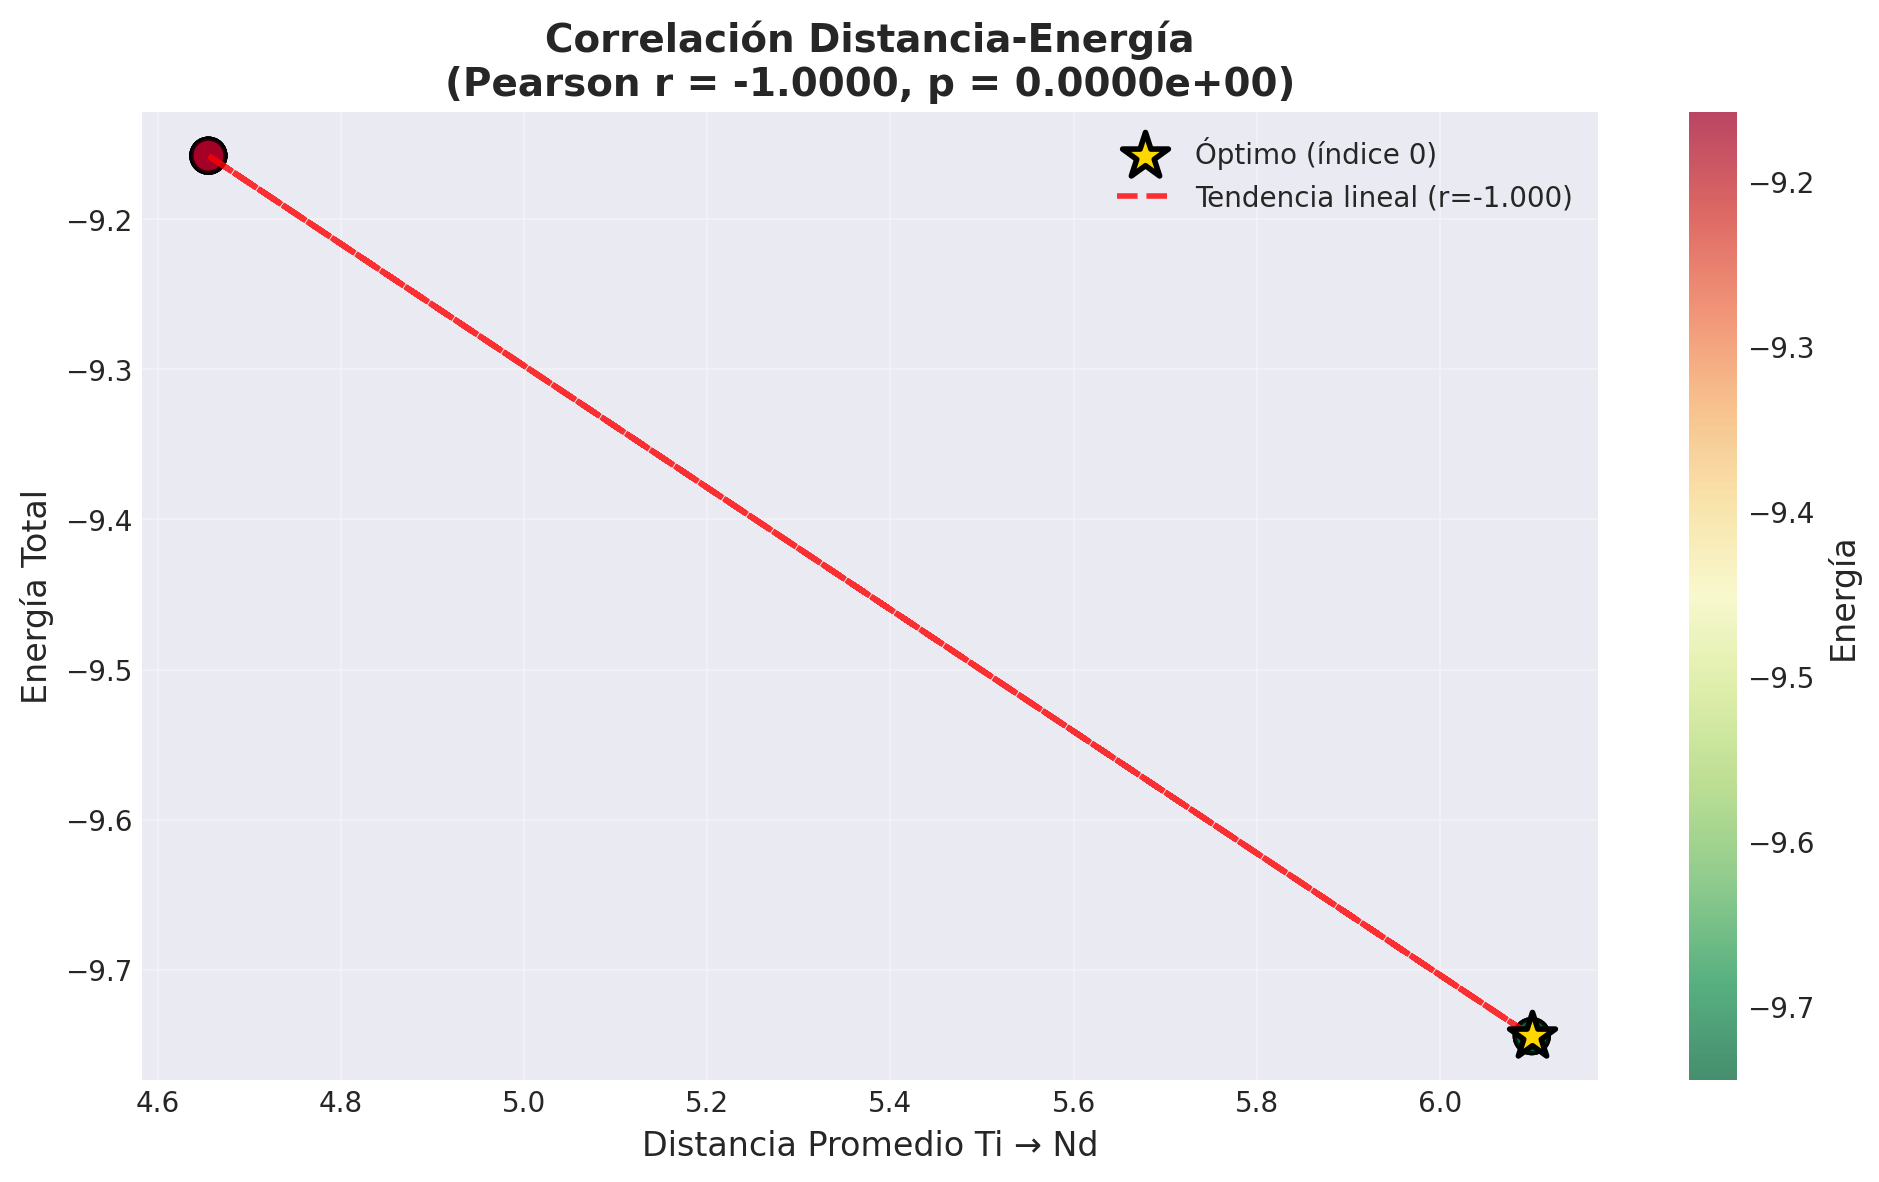


Correlación de Pearson: r = -1.0000
P-value: 0.0000e+00

✓ Correlación NEGATIVA significativa:
  → A MAYOR distancia a Nd, MENOR energía (más estable)
  → CONFIRMA la hipótesis de Skelland


In [13]:
# Calcular distancia promedio a Nd para cada posición
distances_to_Nd = []

for idx in range(grid.n_Fe_sites):
    test_grid = grid.copy()
    test_grid.set_Ti_position(idx)
    contrib = compute_Ti_contributions(test_grid)
    avg_dist = np.mean(contrib['Ti_Nd_distances'])
    distances_to_Nd.append(avg_dist)

distances_to_Nd = np.array(distances_to_Nd)

# Scatter plot: Distancia vs Energía
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(distances_to_Nd, all_energies, s=150, alpha=0.7,
                     c=all_energies, cmap='RdYlGn_r', edgecolors='black', linewidths=1.5)

# Resaltar óptimo
ax.scatter(distances_to_Nd[best_idx], all_energies[best_idx],
           s=300, marker='*', color='gold', edgecolors='black', linewidths=2,
           label=f'Óptimo (índice {best_idx})', zorder=10)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Energía', fontsize=12)

# Regresión lineal
from scipy.stats import pearsonr
corr, p_value = pearsonr(distances_to_Nd, all_energies)

# Línea de tendencia
z = np.polyfit(distances_to_Nd, all_energies, 1)
p = np.poly1d(z)
ax.plot(distances_to_Nd, p(distances_to_Nd), "r--", alpha=0.8, linewidth=2,
        label=f'Tendencia lineal (r={corr:.3f})')

ax.set_xlabel('Distancia Promedio Ti → Nd', fontsize=12)
ax.set_ylabel('Energía Total', fontsize=12)
ax.set_title(f'Correlación Distancia-Energía\n(Pearson r = {corr:.4f}, p = {p_value:.4e})',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCorrelación de Pearson: r = {corr:.4f}")
print(f"P-value: {p_value:.4e}")

if corr < 0 and p_value < 0.05:
    print("\n✓ Correlación NEGATIVA significativa:")
    print("  → A MAYOR distancia a Nd, MENOR energía (más estable)")
    print("  → CONFIRMA la hipótesis de Skelland")
elif corr > 0 and p_value < 0.05:
    print("\n✗ Correlación POSITIVA significativa:")
    print("  → A MENOR distancia a Nd, MENOR energía")
    print("  → CONTRADICE la hipótesis de Skelland")
else:
    print("\n⚠ No hay correlación significativa")

## 3.4. Visualización Final: Mejor vs. Peor Configuración

Comparando esquemas de enfriamiento:

Esquema                             Energía   Óptimo   Accept  Improve
Geométrico (α=0.9)                -9.744382        ✓    0.174    0.172
Geométrico (α=0.95)               -9.744382        ✓    0.178    0.174
Geométrico (α=0.98)               -9.744382        ✓    0.195    0.183
Exponencial (β=0.0005)            -9.744382        ✓    0.861    0.559
Exponencial (β=0.001)             -9.744382        ✓    0.755    0.494
Exponencial (β=0.005)             -9.744382        ✓    0.453    0.322


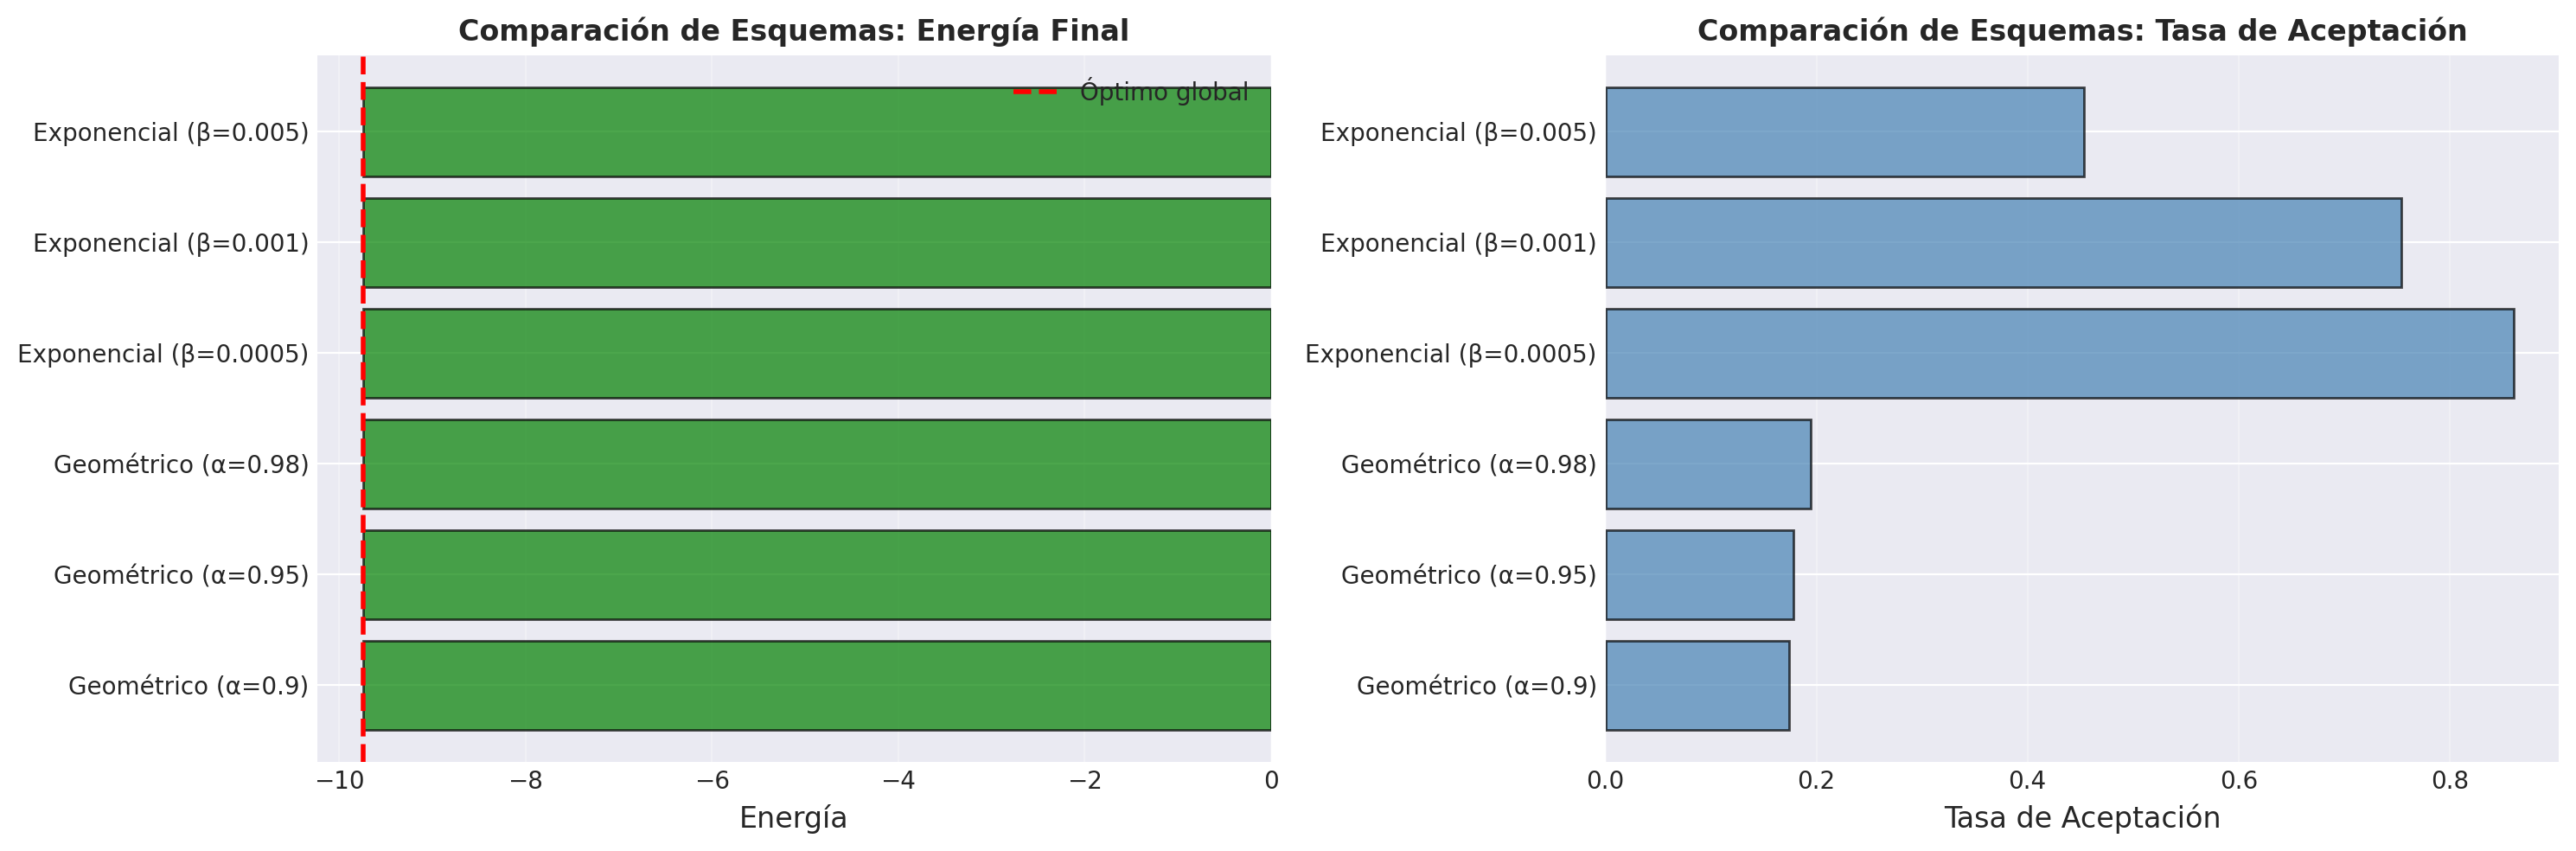

In [14]:
# Comparar diferentes esquemas de enfriamiento
print("Comparando esquemas de enfriamiento:\n")

esquemas_comparacion = {}

# 1. Geométrico con diferentes alphas
for alpha_val in [0.90, 0.95, 0.98]:
    cooling = geometric_cooling(T0=5.0, alpha=alpha_val)
    result = simulated_annealing(grid, T0=5.0, cooling_schedule=cooling,
                                max_iter=15000, seed=42, verbose=False)
    esquemas_comparacion[f'Geométrico (α={alpha_val})'] = result

# 2. Exponencial con diferentes betas
for beta_val in [0.0005, 0.001, 0.005]:
    cooling = exponential_cooling(T0=5.0, beta=beta_val)
    result = simulated_annealing(grid, T0=5.0, cooling_schedule=cooling,
                                max_iter=15000, seed=42, verbose=False)
    esquemas_comparacion[f'Exponencial (β={beta_val})'] = result

# Resultados
print(f"{'Esquema':<30} {'Energía':>12} {'Óptimo':>8} {'Accept':>8} {'Improve':>8}")
print("=" * 80)

for nombre, result in esquemas_comparacion.items():
    found = np.isclose(result['best_energy'], best_energy, atol=1e-6)
    print(f"{nombre:<30} {result['best_energy']:>12.6f} {'✓' if found else '✗':>8} "
          f"{result['acceptance_rate']:>8.3f} {result['improvement_rate']:>8.3f}")

print("=" * 80)

# Visualización comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

nombres = list(esquemas_comparacion.keys())
energias = [esquemas_comparacion[n]['best_energy'] for n in nombres]
accept_rates = [esquemas_comparacion[n]['acceptance_rate'] for n in nombres]

# Energías
colors = ['green' if np.isclose(e, best_energy, atol=1e-6) else 'orange' for e in energias]
ax1.barh(nombres, energias, color=colors, alpha=0.7, edgecolor='black')
ax1.axvline(best_energy, color='red', linestyle='--', linewidth=2, label='Óptimo global')
ax1.set_xlabel('Energía', fontsize=12)
ax1.set_title('Comparación de Esquemas: Energía Final', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# Tasas de aceptación
ax2.barh(nombres, accept_rates, color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Tasa de Aceptación', fontsize=12)
ax2.set_title('Comparación de Esquemas: Tasa de Aceptación', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### Visualización del Grid Search

Heatmaps y análisis visual de todas las combinaciones T₀ × α probadas.

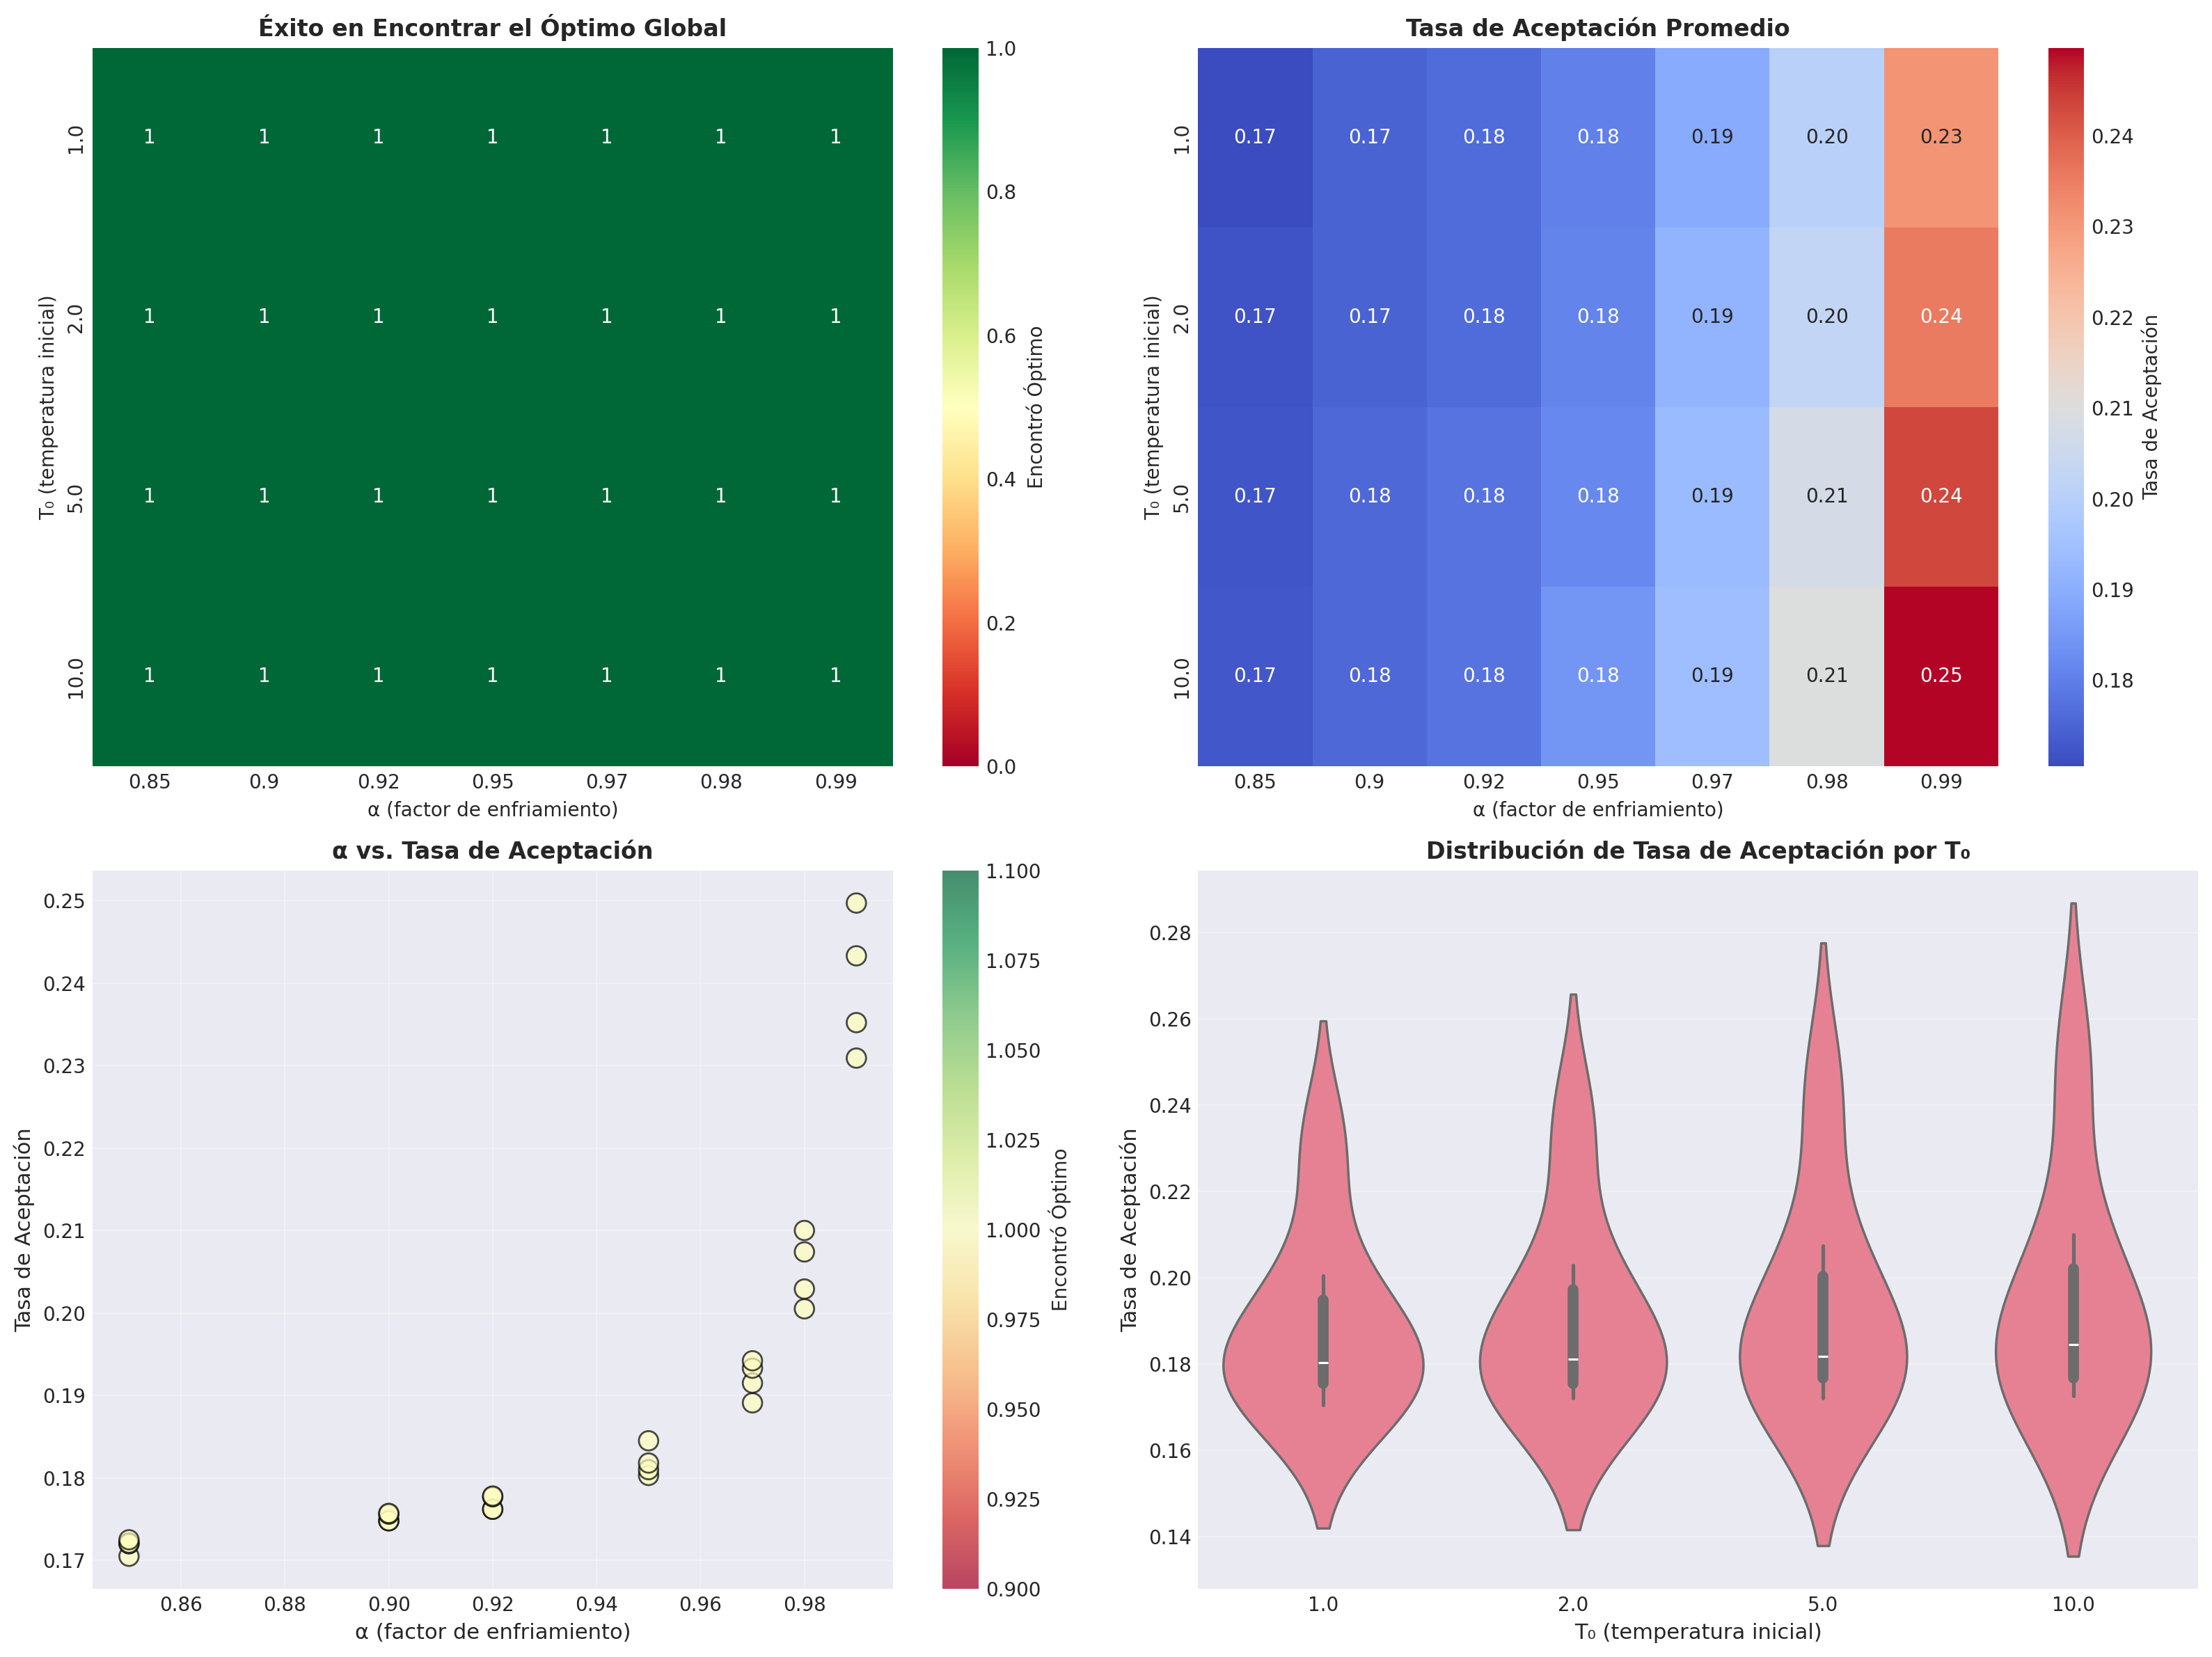


ANÁLISIS ESTADÍSTICO DEL GRID SEARCH

Por Temperatura Inicial (T₀):
     found_optimal     accept_rate        
              mean sum        mean     std
T0                                        
1.0            1.0   7      0.1889  0.0211
2.0            1.0   7      0.1905  0.0225
5.0            1.0   7      0.1930  0.0253
10.0           1.0   7      0.1949  0.0274

Por Factor de Enfriamiento (α):
      found_optimal     accept_rate        
               mean sum        mean     std
alpha                                      
0.85            1.0   4      0.1718  0.0009
0.90            1.0   4      0.1752  0.0005
0.92            1.0   4      0.1770  0.0009
0.95            1.0   4      0.1819  0.0018
0.97            1.0   4      0.1920  0.0023
0.98            1.0   4      0.2052  0.0043
0.99            1.0   4      0.2398  0.0084

Configuraciones exitosas: 28/28
Tasa de éxito global: 100.0%


In [15]:
# Visualización exhaustiva del grid search
# Preparar datos
grid_data = []
for key, result in results_grid.items():
    parts = key.split('_')
    T0_val = float(parts[0].split('=')[1])
    alpha_val = float(parts[1].split('=')[1])
    
    grid_data.append({
        'T0': T0_val,
        'alpha': alpha_val,
        'energy': result['best_energy'],
        'accept_rate': result['acceptance_rate'],
        'found_optimal': 1 if np.isclose(result['best_energy'], best_energy, atol=1e-6) else 0
    })

df_grid = pd.DataFrame(grid_data)

# Crear visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Heatmap de éxito
pivot_success = df_grid.pivot_table(values='found_optimal', index='T0', columns='alpha')
sns.heatmap(pivot_success, annot=True, fmt='.0f', cmap='RdYlGn', 
            vmin=0, vmax=1, cbar_kws={'label': 'Encontró Óptimo'}, ax=axes[0, 0])
axes[0, 0].set_title('Éxito en Encontrar el Óptimo Global', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('α (factor de enfriamiento)')
axes[0, 0].set_ylabel('T₀ (temperatura inicial)')

# 2. Heatmap de tasa de aceptación
pivot_accept = df_grid.pivot_table(values='accept_rate', index='T0', columns='alpha')
sns.heatmap(pivot_accept, annot=True, fmt='.2f', cmap='coolwarm',
            cbar_kws={'label': 'Tasa de Aceptación'}, ax=axes[0, 1])
axes[0, 1].set_title('Tasa de Aceptación Promedio', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('α (factor de enfriamiento)')
axes[0, 1].set_ylabel('T₀ (temperatura inicial)')

# 3. Scatter: alpha vs accept_rate
scatter = axes[1, 0].scatter(df_grid['alpha'], df_grid['accept_rate'],
                             c=df_grid['found_optimal'], cmap='RdYlGn',
                             s=100, alpha=0.7, edgecolors='black', linewidths=1)
axes[1, 0].set_xlabel('α (factor de enfriamiento)', fontsize=11)
axes[1, 0].set_ylabel('Tasa de Aceptación', fontsize=11)
axes[1, 0].set_title('α vs. Tasa de Aceptación', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='Encontró Óptimo')

# 4. Violin plot
sns.violinplot(data=df_grid, x='T0', y='accept_rate', ax=axes[1, 1])
axes[1, 1].set_xlabel('T₀ (temperatura inicial)', fontsize=11)
axes[1, 1].set_ylabel('Tasa de Aceptación', fontsize=11)
axes[1, 1].set_title('Distribución de Tasa de Aceptación por T₀', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Análisis estadístico
print(f"\n{'='*80}")
print("ANÁLISIS ESTADÍSTICO DEL GRID SEARCH")
print(f"{'='*80}")
print(f"\nPor Temperatura Inicial (T₀):")
print(df_grid.groupby('T0').agg({
    'found_optimal': ['mean', 'sum'],
    'accept_rate': ['mean', 'std']
}).round(4))

print(f"\nPor Factor de Enfriamiento (α):")
print(df_grid.groupby('alpha').agg({
    'found_optimal': ['mean', 'sum'],
    'accept_rate': ['mean', 'std']
}).round(4))

best_configs = df_grid[df_grid['found_optimal'] == 1].sort_values('accept_rate')
print(f"\n{'='*80}")
print(f"Configuraciones exitosas: {len(best_configs)}/{len(df_grid)}")
print(f"Tasa de éxito global: {len(best_configs)/len(df_grid)*100:.1f}%")
print(f"{'='*80}")

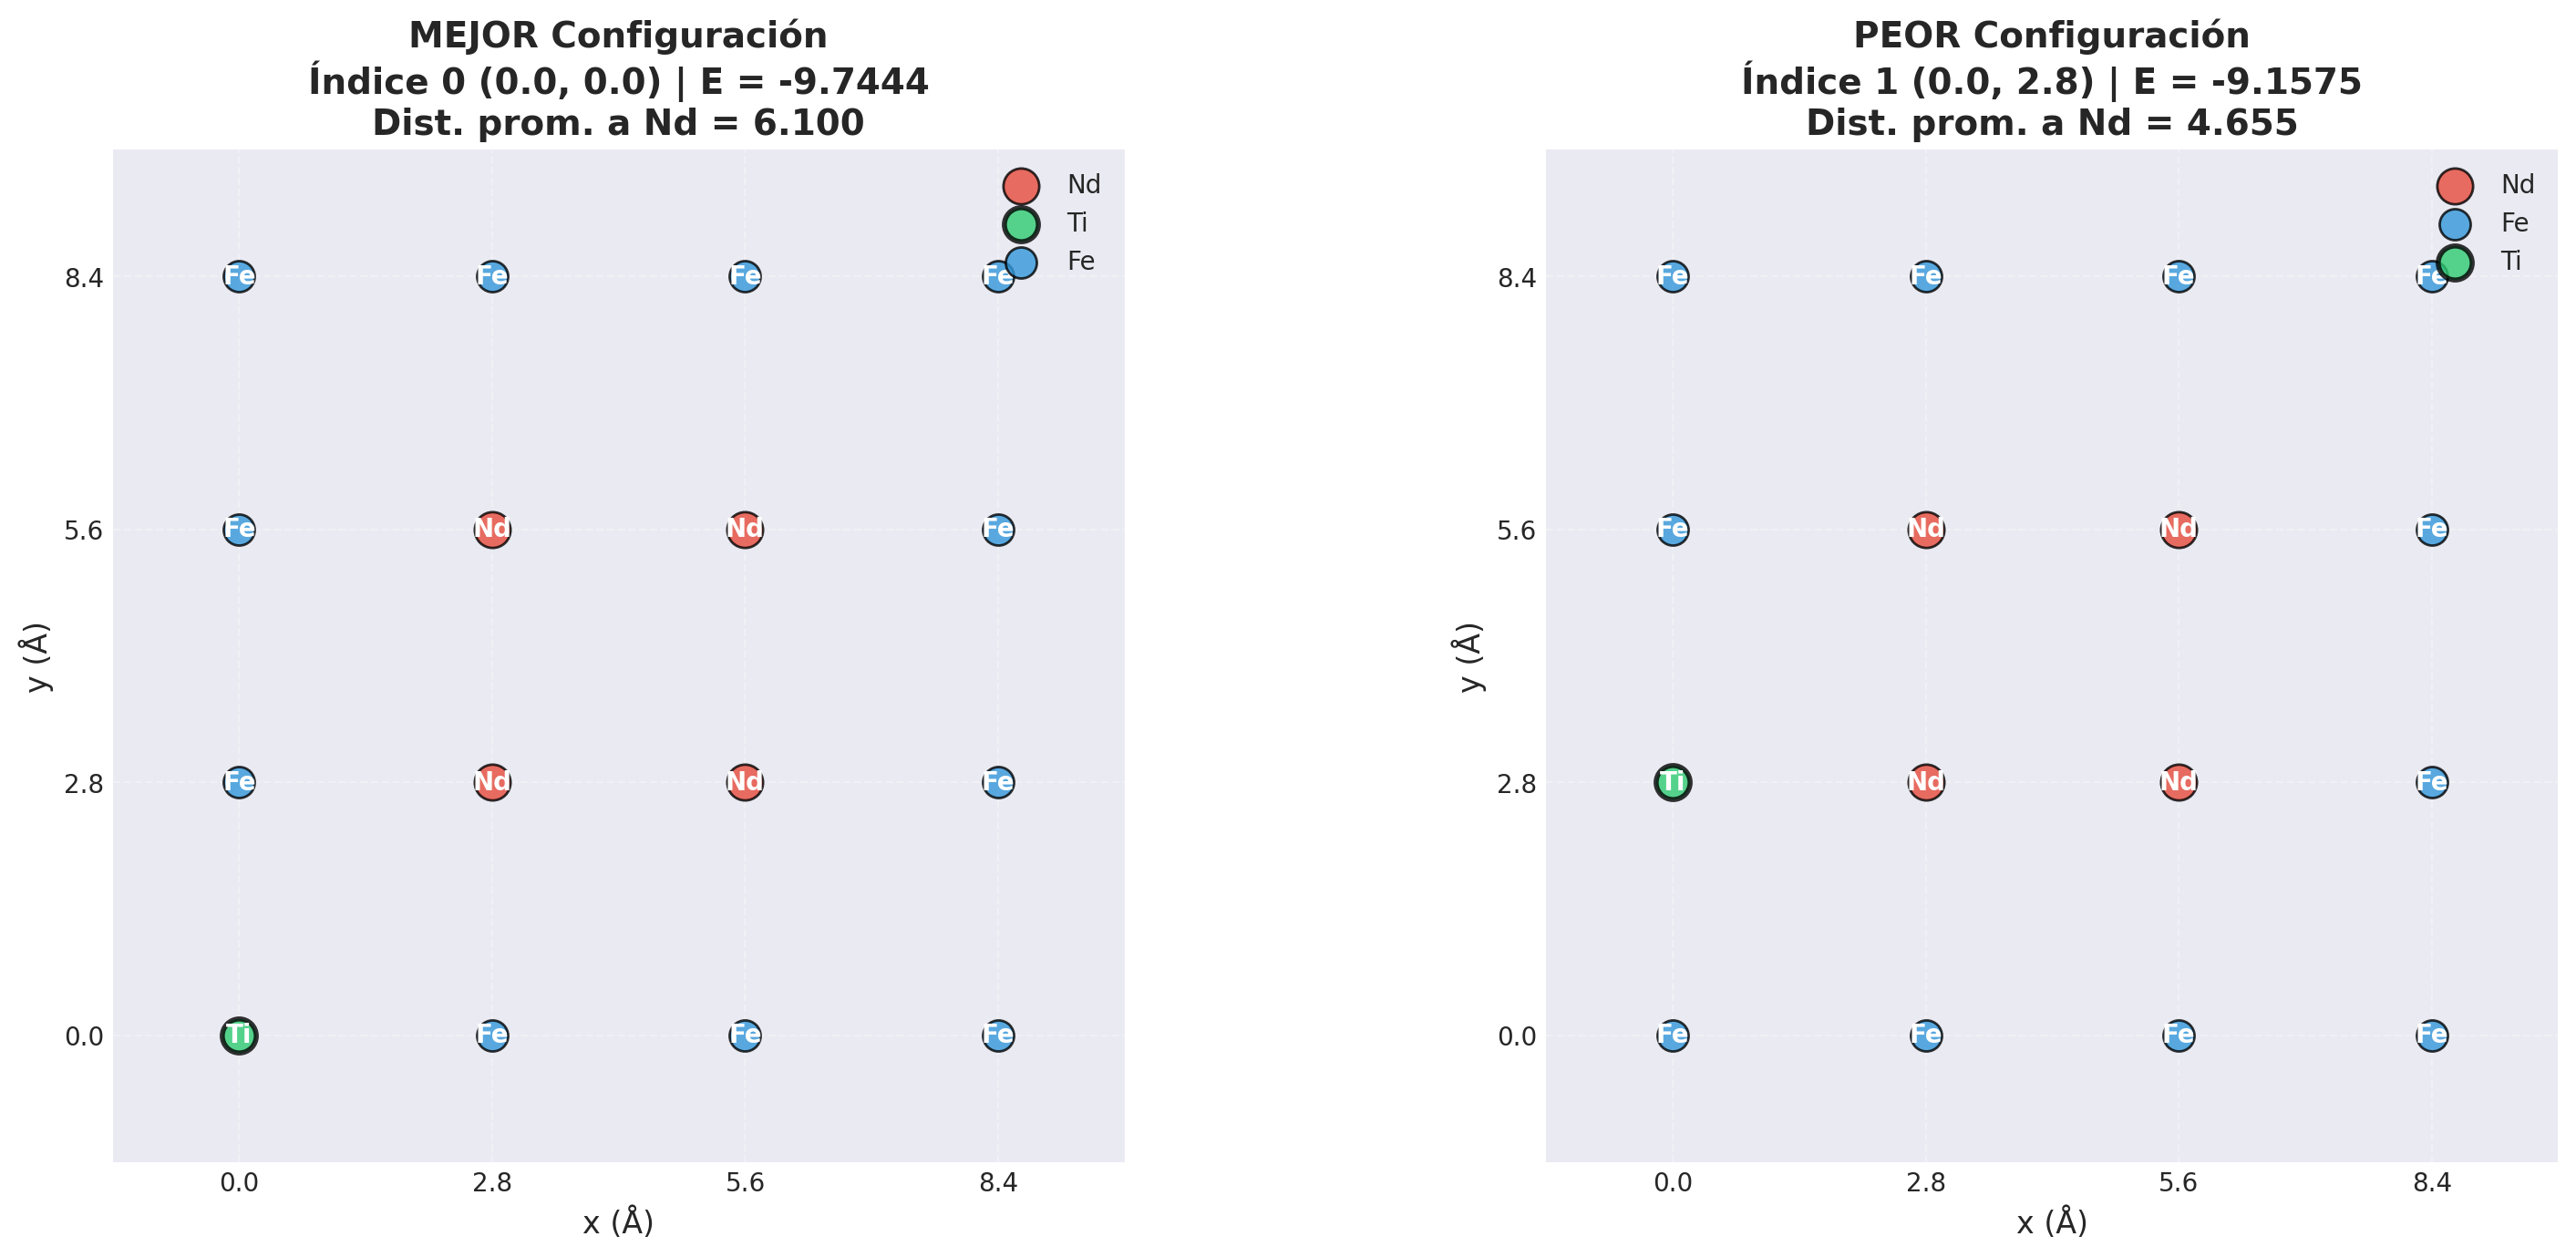

In [16]:
# Comparación lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Mejor
plot_grid_configuration(
    grid_optimal,
    title=f"MEJOR Configuración\nÍndice {best_idx} {Fe_coords[best_idx]} | E = {best_energy:.4f}\nDist. prom. a Nd = {np.mean(contrib_optimal['Ti_Nd_distances']):.3f}",
    highlight_Ti=True,
    show_indices=False,
    ax=ax1
)

# Peor
plot_grid_configuration(
    grid_worst,
    title=f"PEOR Configuración\nÍndice {worst_idx} {Fe_coords[worst_idx]} | E = {worst_energy:.4f}\nDist. prom. a Nd = {np.mean(contrib_worst['Ti_Nd_distances']):.3f}",
    highlight_Ti=True,
    show_indices=False,
    ax=ax2
)

plt.tight_layout()
plt.show()